In [26]:
# @title Importacion de librerias

import numpy as np
import pandas as pd
import re, gdown, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import os

In [27]:
# @title Cargar datos

SHARE_URL = "https://docs.google.com/spreadsheets/d/1TVLAn3GqiO21_6Ir0gbi-Mwf8JpRlV88/edit?usp=sharing&ouid=106056422800690986421&rtpof=true&sd=true"


file_id = re.search(r'/d/([^/]+)', SHARE_URL).group(1)
gdown.download(f"https://drive.google.com/uc?id={file_id}", "trabajo_limpio.xlsx", quiet=False)

df = pd.read_excel("trabajo_limpio.xlsx")
df.head()


Downloading...
From: https://drive.google.com/uc?id=1TVLAn3GqiO21_6Ir0gbi-Mwf8JpRlV88
To: /content/trabajo_limpio.xlsx
100%|██████████| 30.2k/30.2k [00:00<00:00, 17.2MB/s]


,titulo,prom_palabras,links_referencias,cant_comentarios,presentaciones_video,criticas_negativas,copias_vendidas
0,A visual introduction to machine learning,1099,4,2,15,1002,350000
1,What is Machine Learning and how do we use it ...,1888,1,2,2,34,200000
2,Dbrain and the Blockchain of Artificial Intell...,1221,3,8,2,68,200000
3,Nasa finds entire solar system filled with eig...,2039,1,104,4,131,200000
4,200 universities just launched 600 free online...,6462,600,28,2,170,200000


In [28]:
# @title CÓDIGO:

# ============================================
# Clasificación 25–75 unificada: Árbol (Gini) + KNN
# baja: (-inf, p25] | media: (p25, p75] | alta: (p75, inf)
# ============================================

SEED = 42

# --- 1) Features ---
feat_cols = ["prom_palabras","links_referencias","criticas_negativas","presentaciones_video"]
X = df[feat_cols].copy()

# --- 2) Target por percentiles 25 y 75 (con fallback robusto) ---
y_cont = df["copias_vendidas"]
p25, p75 = y_cont.quantile([0.25, 0.75])

if p25 < p75:
    y = pd.cut(
        y_cont, bins=[-np.inf, p25, p75, np.inf],
        labels=["baja","media","alta"], include_lowest=True
    )
else:
    # Fallback raro (muchos empates)
    y = pd.qcut(
        y_cont.rank(method="first"),
        q=[0.0, 0.25, 0.75, 1.0],
        labels=["baja","media","alta"]
    )

print("Percentiles usados -> p25:", p25, " | p75:", p75)

# --- 3) Train/Test estratificado ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=SEED
)

# --- 3.b) Distribución y pesos en TRAIN ---
print("\nDistribución en TRAIN (sin peso):")
print(y_train.value_counts(normalize=True))

# Pesos 'balanced' calculados sobre TRAIN
clases_train = np.array(sorted(y_train.dropna().unique()))
pesos = compute_class_weight(class_weight="balanced", classes=clases_train, y=y_train)
pesos_dict = dict(zip(clases_train, pesos))
print("\nPesos de clase (balanced) sobre TRAIN:")
print(pesos_dict)

# Distribución ponderada (frecuencias * peso de su clase, normalizada)
cnts = y_train.value_counts().reindex(clases_train)
w_cnts = cnts * pd.Series(pesos, index=clases_train)
w_dist = (w_cnts / w_cnts.sum()).rename("proporción_ponderada")

print("\nDistribución en TRAIN ponderada por los pesos:")
print(w_dist)


# --- 4) Definición de pipelines ---
# 4.1) Árbol (Gini)
tree_clf = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("dt", DecisionTreeClassifier(
        criterion="gini",
        max_depth=3,
        min_samples_leaf=8,
        class_weight="balanced",
        random_state=SEED
    ))
])

# 4.2) KNN (con escalado)
knn_clf = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(
        n_neighbors=13,
        weights="distance",   # pondera por distancia
        metric="minkowski",
        p=2
    ))
])

# --- 5) Helper  ---
def evaluar_modelo(nombre, pipe, X_train, y_train, X_test, y_test, feat_cols=None):
    print("\n", "="*70, f"\n>>> {nombre}\n", "="*70, sep="")
    pipe.fit(X_train, y_train)

    # Predicción y proba
    y_pred = pipe.predict(X_test)
    proba = pipe.predict_proba(X_test)
    clases = pipe.named_steps[list(pipe.named_steps.keys())[-1]].classes_
    proba_df = pd.DataFrame(proba, columns=clases, index=X_test.index)

    # Métricas
    acc = accuracy_score(y_test, y_pred)
    f1m = f1_score(y_test, y_pred, average="macro")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1-macro: {f1m:.4f}\n")
    print("Reporte de clasificación:\n", classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred, labels=clases)
    print(f"Matriz de confusión (orden clases = {list(clases)}):\n{cm}\n")

    # ---- extras árbol ----
    if nombre.lower().startswith("árbol") or nombre.lower().startswith("arbol"):
        dt = pipe.named_steps["dt"]
        imps = pd.Series(dt.feature_importances_, index=feat_cols).sort_values(ascending=False)

        print("Reglas del árbol:\n")
        print(export_text(dt, feature_names=feat_cols))

        plt.figure(figsize=(14, 8))
        plot_tree(
            dt, feature_names=feat_cols,
            class_names=[str(c) for c in dt.classes_],
            filled=True, rounded=True
        )
        plt.tight_layout()
        fname = "reports/figures/arbol_gini_25_75.png"
        os.makedirs("reports/figures", exist_ok=True)
        plt.savefig(fname, dpi=200)
        plt.close()
        print(f"\nGuardado: {fname}\n")

    # 👉 acá armamos el diccionario de salida
    result = {
        "modelo": nombre,
        "accuracy": acc,
        "f1_macro": f1m,
        "cm": cm,
        "classes": clases,
        "y_test": y_test,
        "y_pred": y_pred,
    }
    return result


Percentiles usados -> p25: 2800.0  | p75: 36199.0

Distribución en TRAIN (sin peso):
copias_vendidas
media    0.488189
baja     0.259843
alta     0.251969
Name: proportion, dtype: float64

Pesos de clase (balanced) sobre TRAIN:
{np.str_('alta'): np.float64(1.3229166666666667), np.str_('baja'): np.float64(1.2828282828282829), np.str_('media'): np.float64(0.6827956989247311)}

Distribución en TRAIN ponderada por los pesos:
copias_vendidas
alta     0.333333
baja     0.333333
media    0.333333
Name: proporción_ponderada, dtype: float64


In [29]:
# @title Ejecución
res_tree = evaluar_modelo("Árbol (Gini)", tree_clf, X_train, y_train, X_test, y_test, feat_cols=feat_cols)
res_knn  = evaluar_modelo("KNN (k=13, distancia)", knn_clf, X_train, y_train, X_test, y_test)



>>> Árbol (Gini)
Accuracy: 0.5000
F1-macro: 0.4517

Reporte de clasificación:
               precision    recall  f1-score   support

        alta       0.40      0.50      0.44         8
        baja       0.33      0.25      0.29         8
       media       0.62      0.62      0.62        16

    accuracy                           0.50        32
   macro avg       0.45      0.46      0.45        32
weighted avg       0.50      0.50      0.50        32

Matriz de confusión (orden clases = ['alta', 'baja', 'media']):
[[ 4  2  2]
 [ 2  2  4]
 [ 4  2 10]]

Reglas del árbol:

|--- links_referencias <= 7.50
|   |--- prom_palabras <= 1840.50
|   |   |--- criticas_negativas <= 23.50
|   |   |   |--- class: baja
|   |   |--- criticas_negativas >  23.50
|   |   |   |--- class: media
|   |--- prom_palabras >  1840.50
|   |   |--- criticas_negativas <= 90.00
|   |   |   |--- class: alta
|   |   |--- criticas_negativas >  90.00
|   |   |   |--- class: baja
|--- links_referencias >  7.50
|   |--

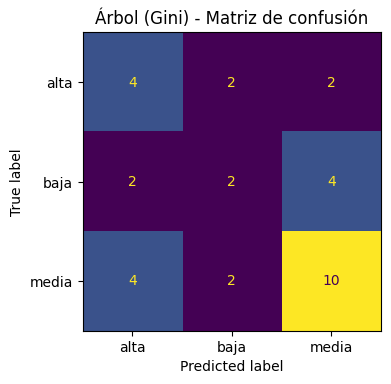

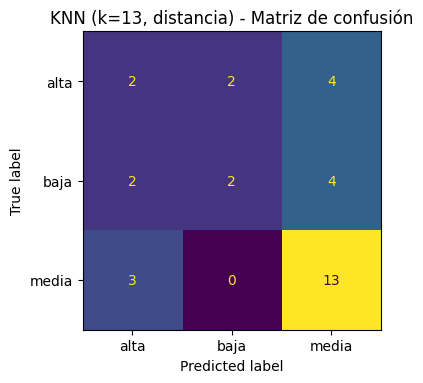

In [30]:
## Matrices de confusion para ambos modelos.

os.makedirs("reports/figures", exist_ok=True)

# nombres de clases (las mismas para ambos modelos)
class_names = list(res_tree["classes"])

# --- Árbol ---
fig, ax = plt.subplots(figsize=(4, 4))
disp = ConfusionMatrixDisplay(
    confusion_matrix=res_tree["cm"],
    display_labels=class_names
)
disp.plot(ax=ax, colorbar=False)
plt.title("Árbol (Gini) - Matriz de confusión")
plt.tight_layout()
plt.savefig("reports/figures/confusion_matrix_tree.png", dpi=150)
plt.show()

# --- KNN ---
fig, ax = plt.subplots(figsize=(4, 4))
disp = ConfusionMatrixDisplay(
    confusion_matrix=res_knn["cm"],
    display_labels=class_names
)
disp.plot(ax=ax, colorbar=False)
plt.title("KNN (k=13, distancia) - Matriz de confusión")
plt.tight_layout()
plt.savefig("reports/figures/confusion_matrix_knn.png", dpi=150)
plt.show()


In [31]:
# @title Comparación rápida de modelos
cmp = pd.DataFrame([res_tree, res_knn]).set_index("modelo").sort_values("f1_macro", ascending=False)
print("\n=== Comparación (ordenado por F1-macro) ===\n", cmp)


=== Comparación (ordenado por F1-macro) ===
                        accuracy  f1_macro                                  cm  \
modelo                                                                          
Árbol (Gini)            0.50000  0.451720  [[4, 2, 2], [2, 2, 4], [4, 2, 10]]   
KNN (k=13, distancia)   0.53125  0.434234  [[2, 2, 4], [2, 2, 4], [3, 0, 13]]   

                                   classes  \
modelo                                       
Árbol (Gini)           [alta, baja, media]   
KNN (k=13, distancia)  [alta, baja, media]   

                                                                  y_test  \
modelo                                                                     
Árbol (Gini)           63     media
47     media
121     baja
158    ...   
KNN (k=13, distancia)  63     media
47     media
121     baja
158    ...   

                                                                  y_pred  
modelo                                                          

In [32]:
# @title Conclusión del modelo: Árbol (Gini) vs KNN

from IPython.display import HTML, display

html = r"""
<style>
  body {
    margin: 0;
    font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
    background: linear-gradient(120deg, #1e1e2f, #2c3e50);
    color: #f0f0f0;
    text-align: center;
    line-height: 1.6;
    overflow-x: hidden;
  }
  h2 {
    color: #00ffe0;
    margin-top: 30px;
    text-shadow: 0 0 5px #00ffe0;
  }
  h3 {
    color: #a8e6ff;
    margin: 0 0 10px 0;
    text-align: left;
  }
  section {
    margin: 30px auto;
    padding: 25px;
    border-radius: 15px;
    background: rgba(255,255,255,0.05);
    width: 85%;
    max-width: 900px;
    box-shadow: 0 0 15px #4cafef;
    transition: transform 0.3s, box-shadow 0.3s;
  }
  section:hover {
    transform: scale(1.02);
    box-shadow: 0 0 25px #4cafef;
  }
  ul {
    text-align: left;
    max-width: 760px;
    margin: 10px auto;
    padding-left: 20px;
  }
  p {
    text-align: justify;
    text-justify: inter-word;
    margin: 0.4rem 0;
  }
  .pill {
    display: inline-block;
    padding: 4px 10px;
    border: 1px solid #4cafef;
    border-radius: 999px;
    margin: 4px 6px;
    font-size: 0.9rem;
    background: rgba(76,175,239,0.08);
  }
  table {
    width: 100%;
    border-collapse: collapse;
    margin-top: 8px;
    background: rgba(0,0,0,0.25);
  }
  th, td {
    border: 1px solid rgba(255,255,255,0.2);
    padding: 10px;
    text-align: center;
  }
  th {
    background: rgba(255,255,255,0.08);
  }
  .tag {
    color: #00ffe0;
    font-weight: 600;
  }
</style>

<section style="padding: 1rem; border: 2px solid #4cafef; border-radius: 10px;">
  <h2>🧠 Conclusión del Experimento: Árbol (Gini) vs KNN</h2>
</section>

<section>
  <h3>🎯 Objetivo</h3>
  <p>Predecir la cantidad de copias vendidas por libro clasificándolas en tres niveles: <span class="pill">baja</span><span class="pill">media</span><span class="pill">alta</span>.</p>
  <p>Se aplicaron dos algoritmos de clasificación: <span class="tag">Árbol de Decisión (Gini)</span> y <span class="tag">K-Vecinos más Cercanos (KNN)</span>.</p>
</section>

<section>
  <h3>🧹 Preparación de los datos</h3>
  <ul>
    <li><b>Variables (features):</b> <code>prom_palabras</code>, <code>links_referencias</code>, <code>criticas_negativas</code>, <code>presentaciones_video</code>. Se excluyó <code>cantidad_comentarios</code> por degradar las métricas.</li>
    <li><b>Target (3 clases por percentiles 25/75):</b> baja ≤ p25; media (p25, p75]; alta &gt; p75. Reemplaza la división en tercios (peor desempeño).</li>
    <li><b>Desbalance:</b> en el árbol se aplicó <code>class_weight="balanced"</code>.</li>
    <li><b>Split:</b> 80% entrenamiento / 20% testeo, <b>estratificado</b>.</li>
    <li><b>Imputación:</b> por mediana en faltantes. Para KNN además <b>escalado estándar</b> (sensibilidad a magnitudes).</li>
  </ul>
</section>

<section>
  <h3>🧪 Modelos aplicados</h3>
  <ul>
    <li><b>Árbol de Decisión (Gini):</b> mejor que <i>entropy</i> en este caso; se ajustaron <i>max_depth</i> y <i>min_samples_leaf</i> para evitar sobreajuste.</li>
    <li><b>KNN:</b> se evaluaron k=1..99 y se seleccionó <b>k=13</b> (mejor métricas), con <code>weights="distance"</code> y distancia de Minkowski (<i>p</i>=2).</li>
  </ul>
</section>

<section>
  <h3>📈 Resultados</h3>
  <table>
    <thead>
      <tr>
        <th>Modelo</th>
        <th>Accuracy</th>
        <th>F1-macro</th>
      </tr>
    </thead>
    <tbody>
      <tr>
        <td>Árbol (Gini)</td>
        <td>0.500</td>
        <td>0.452</td>
      </tr>
      <tr>
        <td>KNN (k=13, distancia)</td>
        <td>0.531</td>
        <td>0.434</td>
      </tr>
    </tbody>
  </table>
  <ul>
    <li>Ambos modelos rinden de forma similar (≈50% accuracy).</li>
    <li>El árbol logra <b>F1-macro</b> levemente superior; KNN obtiene algo más de <b>accuracy</b>.</li>
    <li>Las clases extremas (<i>baja</i>, <i>alta</i>) son las más difíciles; <i>media</i> se recupera mejor.</li>
    <li>En el árbol, <b>links_referencias</b> y <b>criticas_negativas</b> aparecen como variables más influyentes.</li>
  </ul>
</section>

<section>
  <h3>🧐 Interpretación final</h3>
  <p>El desempeño (accuracy ~0.50 y F1-macro ~0.45) es <b>moderado</b> y está limitado principalmente por los datos, no por el algoritmo.</p>
  <ul>
    <li><b>Pocos datos:</b> poca evidencia para aprender patrones robustos.</li>
    <li><b>Baja correlación con el target:</b> algunas features (p.ej. <code>presentaciones_video</code>) aportan poca señal.</li>
    <li><b>Límites difusos de clases:</b> cortes en p25/p75 generan solapamientos (especialmente en <i>media</i>).</li>
    <li><b>Desbalance relativo:</b> aun con <code>class_weight="balanced"</code> la performance en extremos sufre.</li>
    <li><b>Ruido/variabilidad:</b> pequeñas diferencias en features no reflejan cambios reales en ventas.</li>
  </ul>
  <p>Ambos modelos captan cierta estructura (superan el 33% del azar en 3 clases), pero no alcanzan precisión suficiente para uso práctico.</p>
</section>

<section>
  <h3>🚀 Recomendaciones para mejorar</h3>
  <ul>
    <li><b>Más datos:</b> ampliar el conjunto de observaciones.</li>
    <li><b>Nuevas variables:</b> tipo y género del libro, campañas, precio, temporalidad, etc.</li>
    <li><b>Rebalanceo y transformaciones:</b> técnicas que aumenten separabilidad entre clases.</li>
  </ul>
  <p><b>En síntesis:</b> el cuello de botella está en los <b>datos</b>; con las variables actuales hay poca información útil para distinguir entre ventas bajas, medias y altas.</p>
</section>
"""

display(HTML(html))


Modelo,Accuracy,F1-macro
Árbol (Gini),0.500,0.452
"KNN (k=13, distancia)",0.531,0.434
